In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import KFold 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import *
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot,plot_model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.preprocessing import LabelBinarizer
import random

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 数据处理
##  读取数据索引文件


数据集为所有的标签图片提供了索引文件，读取其中的所有文件，索引文件包括了22424张不同司机的图片，其中包括了司机ID,司机图片名称，司机驾驶分类名称

In [2]:
index_data=pd.read_csv("driver_imgs_list.csv")

## 司机ID图片数量的分布

根据所有文件对数据集中，图片数据的分布进行探索，按照司机的ID对不同的司机图片数量进行统计，得到下面的统计图片，从图片中可以看出，不同的司机ID在
图片的分布上面存在这较大的差异，数量较多的达到1200张以上，数量较少的在300张左右。

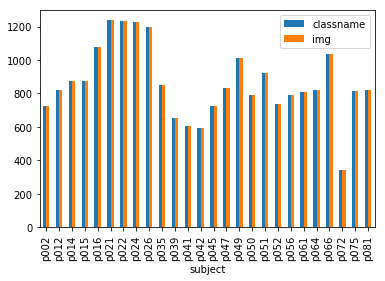

In [32]:
driver_data=index_data.groupby("subject").count()
driver_data.plot(kind="bar")
plt.show()

## 司机行为图片数量分布图

根据不同的司机分类状态，即
- c0: 安全驾驶
- c1: 右手打字
- c2: 右手打电话
- c3: 左手打字
- c4: 左手打电话
- c5: 调收音机
- c6: 喝饮料
- c7: 拿后面的东西
- c8: 整理头发和化妆
- c9: 和其他乘客说话

这些状态下面图片数量的分布如下图所示，可以看出，相对司机ID分类的情况，不同驾驶状态上面图片分布相对均匀，图片数量相对都在2000张图片左右

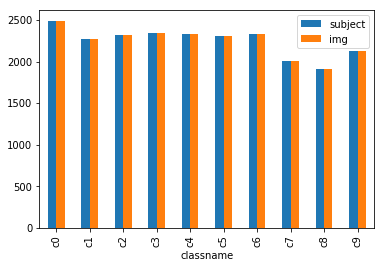

In [4]:
driver_class=index_data.groupby("classname").count()
driver_class.plot(kind="bar")
plt.show()

## 不同司机驾驶状态分布图

不同司机在不同状态上面的分布如下图所示，下面分别对不同司机ID的图片分布进行了统计，结果如下图所示，在下图中可以看出，不同司机在不同状态上面的分布差别较大，某些司机在某些状态下面的数量较少，而另外一些状态下面数量较多

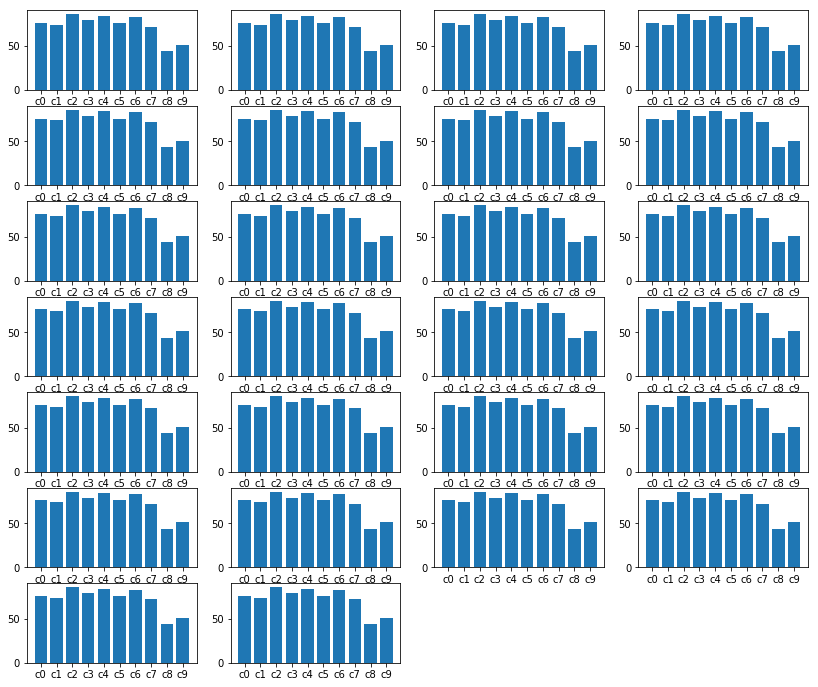

In [16]:
driver_ID=index_data["subject"].unique()
i=1
plt.figure(figsize=(14,12))
for ID in driver_ID:
    X=index_data[index_data["subject"]==ID].groupby("classname").count()["img"]
    X=["c0","c1","c2","c3","c4","c5","c6","c7","c8","c9"]
    plt.subplot(7,4,i)
    plt.bar(X,Y)
    i+=1
plt.show()

# 构建模型

在基准模型上面，我选择的是Vgg16模型，主要基于以下两个原因：
- 经典模型，模型层数较少，容易训练
- kaggle论坛上面有大量使用vgg16模型达到较好成绩
- keras中提供了vgg16的预训练模型
- 模型结构清晰，较容易理解和修改

## 参数的设置

这里主要设置的是vgg16规定中的图片的像素长度、宽度、及颜色通道数量，项目通过了aws云服务器上面通过GPU进行计算，根据选择的GPU的大小，设置了batch_size，避免由于内存资源不够而报错

In [4]:
img_rows=224
img_cols=224
n_channel=3
batch_size=16

## KFold划分训练集、验证集

项目是通过司机ID对数据集划分训练集和验证集，项目中训练数据只有24000多张，而测试数据达到7900多张。在这种情况下面，标签过的训练集数据量相对较少，为了进一步提高模型的性能，方法之一就是，让模型尽量训练到所有标签过的数据，所以这使用了K-Fold方式根据司机ID划分了不同的训练集ID,验证集ID,这里把所有数据集划分为8次 KFold的结果，结果如下所示，划分了8组验证集ID及训练集ID.

In [4]:
driver_ID=index_data['subject'].unique()
kfold = KFold(n_splits=8, shuffle=True, random_state=50)  
for train_index,val_index in kfold.split(driver_ID):
    val_ID=driver_ID[val_index] 
    print(val_ID)

['p026' 'p035' 'p042' 'p075']
['p047' 'p049' 'p064' 'p081']
['p015' 'p051' 'p072']
['p024' 'p039' 'p061']
['p014' 'p052' 'p066']
['p021' 'p022' 'p056']
['p012' 'p016' 'p045']
['p002' 'p041' 'p050']


## 多分类标签热独编码函数

项目是对数据图片进行10分类的计算机视觉问题，而分类状态需要通过热独编码把“c0”、“c1”、“c2”等十个分类，编码成为二进制中数据中的一项，方便神经网络全连接层连接计算。

In [5]:
def one_hot_encode(x):
    x=np.array(x)
    label_binarizer = LabelBinarizer() 
    label_binarizer.fit(range(10))
    return label_binarizer.transform(x)

## 读入训练图片和验证图片函数

在这里因为使用了云计算服务器，标签数据主要有2个GB的数据，可以直接读入到内存中训练，这里主要是根据划分出的训练集ID、验证集ID在文件夹下面，在分类好的文件夹下面读入相应的图片，生成测试集的图片及相应分类标签，测试集的图片及分类标签。

In [6]:
def read_picture(val_ID):
    val_index=index_data[index_data["subject"].isin(val_ID)]
    val_count=len(val_index)
    train_count=len(index_data)-val_count
    train_X=np.zeros((train_count,img_rows,img_cols,3),dtype=np.uint8)
    train_Y=np.zeros((train_count,1),dtype=np.uint8)
    val_X=np.zeros((val_count,img_rows,img_cols,3),dtype=np.uint8)
    val_Y=np.zeros((val_count,1),dtype=np.uint8)
    index_1=0
    index_2=0
    for i in range(10):
        dir_path="./train/"+"c"+str(i)
        file_list=os.listdir(dir_path)
        for img in file_list:
            img_path=os.path.join(dir_path,img)
            x= image.load_img(img_path, target_size=(img_rows, img_cols))
            x = image.img_to_array(x)
            x = np.expand_dims(x, axis=0)
            if img in val_index["img"].tolist():
                val_X[index_1]=x
                val_Y[index_1]=i
                index_1+=1
            else:
                train_X[index_2]=x
                train_Y[index_2]=i
                index_2+=1
    
    return train_X,one_hot_encode(train_Y),val_X,one_hot_encode(val_Y)               

## 定义数据增强

项目中，由于照片拍摄角度、光线等原因原始的训练数据并不能提供这些内容，这里使用了数据增强的功能，对原始训练集中的图片做一些增强，包括旋转一定角度、缩放一定角度、图片高度和长度平移一定的角度。通过数据增强可以提高模型的泛化能力。在这一过程中，需要注意的内容包括以下几点：
- 训练数据经过了数据增强，并且由于图片是连续视频中得到的内容，为了避免训练中出现相似度较高的图片同一时间出现，需要把训练数据打乱进行shuffle处理
- 验证数据为了和测试数据一致，并没有经过数据增强的处理，并且不需要打乱数据
- 测试数据因为数据量较大大约6GB左右，需要使用生成器分批读入数据并且不需要打乱数据处理

In [7]:
def Augmentation_data(train_X,train_Y,val_X,val_Y):
    datagen = ImageDataGenerator(shear_range=0.1,
                                 zoom_range=0.1, 
                                 rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1
                                )
    val_datagen=ImageDataGenerator()
    test_datagen=ImageDataGenerator()
    train_gen=datagen.flow(train_X,train_Y,batch_size=batch_size,shuffle=True)
    val_gen=val_datagen.flow(val_X,val_Y,batch_size=batch_size,shuffle=False)
    test_gen=test_datagen.flow_from_directory("./link", target_size=(224,224), class_mode=None, shuffle=False, batch_size=batch_size)
    return train_gen,val_gen,test_gen

## 构建VGG16模型函数

项目使用vgg16作为基准模型，模型使用keras提供的预训练模型，并且采用imagenet提供的预训练模型初始化模型权重，主要步骤为：
 - 首先定义一个输入图片的格式，此处为（224,224,3）这是vgg16模型论文中的默认格式
 - 对图片通过预处理函数vgg16.preprocess_input进行处理，这里主要是把图片向量进行中心化处理，以便模型的训练
 - 构建vgg16的基准模型，并且把全连接层打开include_top=False,模型最后的输出使用gobalaverage的方式进行参数的维度的压扁
 - 添加全连接层，主要的是全连接的参数，这里默认的模型参数为4096的两个全连接层，经过调参后发现连接2048个参数的情况，模型验证集效果较好
 - 项目中因为是连续视频流截图，图片相似度较高，容易过拟合，在全连接后添加了Dropuout层，来控制反向传播引起的模型过拟合问题，并且通过调参设置0.5
 - 最后模型参数连接到10个分类，作为模型的输出层

In [8]:
def build_model_VGG16():
    x=Input(shape=(224,224,3))
    x=Lambda(vgg16.preprocess_input)(x)
    base_model=VGG16(include_top=False,weights="imagenet",input_tensor=x,pooling="avg")
    x=Dense(512,activation="relu",name="fc1")(base_model.output)
    x=Dropout(0.5)(x)
    x=Dense(512,activation="relu",name="fc2")(x)
    x=Dropout(0.5)(x)
    x=Dense(10, activation='softmax', name='predictions')(x)  
    model=Model(base_model.input,x)
    return model

## 训练模型函数

kaggel对走神司机项目的评估是通过logloss来进行评估，所以，在训练过程中，我们需要关注的是val_loss的变化情况，模型训练的几个重点：
- 优化器的选择，这里选择了Adam作为优化器，和经典的梯度下降优化SGD相比，它的特点是对稀疏矩阵构成的矩阵，梯度下降更快，效率更高。
- 在训练过程中，我们需要设置检查点checkpoint,主要检测val_loss的变化，并且保存val_loss最好的模型的权重情况
- 训练过程中，训练时间是较多的，为了避免在过拟合的情况下，还进入跟多epoch的训练，这里设置了eralystopping作为一个断点，当2个epoches的情况下val_loss没有改进，则认为模型开始进入过拟合的搜索阶段，停止训练，并且保存最好val_loss的模型权重。
- 关于学习率的设置，这是CNN模型训练中的关键参数，通过多次的实验，当learning-rate=le-5的时候可以得到较小的val_loss


In [19]:
def fit_model(model,nfold,train_gen,val_gen):
    print(str(nfold)+" "+"round training is beging")
    model_fold="model"+"_"+str(nfold)+"_weights"+".hdf5"
    earlystopping=EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='min')
    checkpoint = ModelCheckpoint(filepath=model_fold,monitor='val_loss',mode='auto',save_best_only=True,save_weights_only=True)
    adm=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=adm,loss="categorical_crossentropy",metrics=["accuracy"])
    hist=model.fit_generator(train_gen,epochs=10,validation_data=val_gen,callbacks=[checkpoint,earlystopping])
    print(str(nfold)+" "+"round training finished")
    return hist

## 测试模型函数

kaggle 需要提交的文件是一个测试图片的预测文件，这里需要生成79000多个文件的预测结果，并且把结果提交kaggle进行评分，下面的函数是生成预测结果的函数，由于测试集较大，是通过生成器批量生成数据，所以在预测的时候是通过predict_generator生成器分批生成测试结果，生成一个CSV文件提交kaggel进行评分

In [9]:
def get_test_result(model,generator, result_file_name="default"):
    classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
    print("Now to predict result!")
    pred_test = model.predict_generator(generator, len(generator), verbose=1)
    pred_test = np.array(pred_test)
    pred_test = pred_test.clip(min=0.005, max=0.995)
    
    print("Creating datasheet!")
    result = pd.DataFrame(pred_test, columns=classes)
    test_filenames = []
    for f in generator.filenames:
        test_filenames.append(os.path.basename(f))
    result.loc[:, 'img'] = pd.Series(test_filenames, index=result.index)
    result.to_csv(result_file_name, index=None)
    
    print ('Test result file %s generated!' % (result_file_name))

# 训练模型

## 执行KFold训练模型

In [17]:
val_ID=['p026','p035','p042','p075']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_gen,val_gen,test_gen=Augmentation_data(train_X,train_Y,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,1,train_gen,val_gen)
model.load_weights("model_1_weights.hdf5")
get_test_result(model,test_gen,"vgg1.csv")

Found 79726 images belonging to 1 classes.
1 round training is beging
Epoch 1/10
1186/1186 [==============================] - 687s 580ms/step - loss: 2.1683 - acc: 0.1899 - val_loss: 1.3368 - val_acc: 0.4665
Epoch 2/10
1186/1186 [==============================] - 678s 572ms/step - loss: 0.9532 - acc: 0.6636 - val_loss: 0.3322 - val_acc: 0.9014
Epoch 3/10
1186/1186 [==============================] - 677s 571ms/step - loss: 0.2403 - acc: 0.9248 - val_loss: 0.2435 - val_acc: 0.9037
Epoch 4/10
1186/1186 [==============================] - 675s 569ms/step - loss: 0.1101 - acc: 0.9700 - val_loss: 0.4888 - val_acc: 0.8437
Epoch 5/10
1186/1186 [==============================] - 674s 568ms/step - loss: 0.0652 - acc: 0.9815 - val_loss: 0.3801 - val_acc: 0.8875
1 round training finished
Now to predict result!
4983/4983 [==============================] - 1414s 284ms/step
Creating datasheet!
Test result file vgg1.csv generated!


上述单模型kaggle评分 private sore 0.34

In [20]:
val_ID=['p047','p049','p064','p081']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_gen,val_gen,test_gen=Augmentation_data(train_X,train_Y,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,2,train_gen,val_gen)
model.load_weights("model_2_weights.hdf5")
get_test_result(model,test_gen,"vgg2.csv")

Found 79726 images belonging to 1 classes.
2 round training is beging
Epoch 1/10
1184/1184 [==============================] - 710s 600ms/step - loss: 1.2352 - acc: 0.5595 - val_loss: 0.5039 - val_acc: 0.8624
Epoch 2/10
1184/1184 [==============================] - 704s 594ms/step - loss: 0.1254 - acc: 0.9654 - val_loss: 0.5059 - val_acc: 0.8449
Epoch 3/10
1184/1184 [==============================] - 702s 593ms/step - loss: 0.0589 - acc: 0.9838 - val_loss: 0.4530 - val_acc: 0.8702
Epoch 4/10
1184/1184 [==============================] - 701s 592ms/step - loss: 0.0330 - acc: 0.9906 - val_loss: 0.4885 - val_acc: 0.8836
Epoch 5/10
1184/1184 [==============================] - 699s 591ms/step - loss: 0.0245 - acc: 0.9931 - val_loss: 0.7296 - val_acc: 0.8146
2 round training finished
Now to predict result!
4983/4983 [==============================] - 879s 176ms/step
Creating datasheet!
Test result file vgg2.csv generated!


上述模型kaggle评分 private score0.51

In [11]:
val_ID=['p015','p051','p072']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_gen,val_gen,test_gen=Augmentation_data(train_X,train_Y,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,3,train_gen,val_gen)
model.load_weights("model_3_weights.hdf5")
get_test_result(model,test_gen,"vgg3.csv")

Found 79726 images belonging to 1 classes.
3 round training is beging
Epoch 1/10
1268/1268 [==============================] - 746s 589ms/step - loss: 1.3746 - acc: 0.4975 - val_loss: 0.7715 - val_acc: 0.7795
Epoch 2/10
1268/1268 [==============================] - 735s 579ms/step - loss: 0.1248 - acc: 0.9638 - val_loss: 0.7066 - val_acc: 0.8365
Epoch 3/10
1268/1268 [==============================] - 733s 578ms/step - loss: 0.0578 - acc: 0.9824 - val_loss: 0.7885 - val_acc: 0.8197
Epoch 4/10
1268/1268 [==============================] - 732s 577ms/step - loss: 0.0430 - acc: 0.9884 - val_loss: 0.8533 - val_acc: 0.8160
3 round training finished
Now to predict result!
4983/4983 [==============================] - 877s 176ms/step
Creating datasheet!
Test result file vgg3.csv generated!


上述模型kaggle评分 private score0.39

In [10]:
val_ID=['p024','p039','p061']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_gen,val_gen,test_gen=Augmentation_data(train_X,train_Y,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,4,train_gen,val_gen)
model.load_weights("model_4_weights.hdf5")
get_test_result(model,test_gen,"vgg4.csv")

Found 79726 images belonging to 1 classes.
4 round training is beging
Epoch 1/10
1234/1234 [==============================] - 768s 623ms/step - loss: 2.1330 - acc: 0.2105 - val_loss: 1.3562 - val_acc: 0.5331
Epoch 2/10
1234/1234 [==============================] - 712s 577ms/step - loss: 0.6995 - acc: 0.7729 - val_loss: 0.5610 - val_acc: 0.8313
Epoch 3/10
1234/1234 [==============================] - 704s 570ms/step - loss: 0.2171 - acc: 0.9365 - val_loss: 0.6744 - val_acc: 0.8496
Epoch 4/10
1234/1234 [==============================] - 701s 568ms/step - loss: 0.1159 - acc: 0.9679 - val_loss: 0.4447 - val_acc: 0.8831
Epoch 5/10
1234/1234 [==============================] - 700s 567ms/step - loss: 0.0703 - acc: 0.9808 - val_loss: 0.6105 - val_acc: 0.8533
Epoch 6/10
1234/1234 [==============================] - 698s 566ms/step - loss: 0.0512 - acc: 0.9860 - val_loss: 0.5193 - val_acc: 0.8768
4 round training finished
Now to predict result!
4983/4983 [==============================] - 1395s 28

 上述模型kaggle评分 private score0.43

In [11]:
val_ID=['p014', 'p052','p066']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_gen,val_gen,test_gen=Augmentation_data(train_X,train_Y,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,5,train_gen,val_gen)
model.load_weights("model_5_weights.hdf5")
get_test_result(model,test_gen,"vgg5.csv")

Found 79726 images belonging to 1 classes.
5 round training is beging
Epoch 1/10
1236/1236 [==============================] - 706s 571ms/step - loss: 2.3070 - acc: 0.1273 - val_loss: 2.1096 - val_acc: 0.2592
Epoch 2/10
1236/1236 [==============================] - 704s 569ms/step - loss: 1.2389 - acc: 0.5618 - val_loss: 0.6548 - val_acc: 0.8396
Epoch 3/10
1236/1236 [==============================] - 703s 569ms/step - loss: 0.2761 - acc: 0.9165 - val_loss: 0.4618 - val_acc: 0.8981
Epoch 4/10
1236/1236 [==============================] - 702s 568ms/step - loss: 0.1211 - acc: 0.9670 - val_loss: 0.4560 - val_acc: 0.8694
Epoch 5/10
1236/1236 [==============================] - 701s 567ms/step - loss: 0.0724 - acc: 0.9808 - val_loss: 0.8626 - val_acc: 0.7951
Epoch 6/10
1236/1236 [==============================] - 700s 566ms/step - loss: 0.0516 - acc: 0.9860 - val_loss: 0.4398 - val_acc: 0.9125
Epoch 7/10
1236/1236 [==============================] - 699s 566ms/step - loss: 0.0416 - acc: 0.9889 -

上述模型kaggle评分 privete score0.45

In [12]:
val_ID=['p021','p022','p056']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_gen,val_gen,test_gen=Augmentation_data(train_X,train_Y,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,6,train_gen,val_gen)
model.load_weights("model_6_weights.hdf5")
get_test_result(model,test_gen,"vgg6.csv")

Found 79726 images belonging to 1 classes.
6 round training is beging
Epoch 1/10
1198/1198 [==============================] - 692s 578ms/step - loss: 2.2617 - acc: 0.1546 - val_loss: 1.5538 - val_acc: 0.5003
Epoch 2/10
1198/1198 [==============================] - 690s 576ms/step - loss: 0.8356 - acc: 0.7178 - val_loss: 0.4130 - val_acc: 0.8765
Epoch 3/10
1198/1198 [==============================] - 689s 575ms/step - loss: 0.2039 - acc: 0.9390 - val_loss: 0.2174 - val_acc: 0.9335
Epoch 4/10
1198/1198 [==============================] - 687s 574ms/step - loss: 0.1053 - acc: 0.9706 - val_loss: 0.5739 - val_acc: 0.8940
Epoch 5/10
1198/1198 [==============================] - 686s 573ms/step - loss: 0.0696 - acc: 0.9811 - val_loss: 0.2085 - val_acc: 0.9467
Epoch 6/10
1198/1198 [==============================] - 685s 572ms/step - loss: 0.0506 - acc: 0.9863 - val_loss: 0.1503 - val_acc: 0.9547
Epoch 7/10
1198/1198 [==============================] - 684s 571ms/step - loss: 0.0398 - acc: 0.9891 -

上述模型kaggle评分 privete score0.38

In [16]:
val_ID=['p012','p016','p045']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_gen,val_gen,test_gen=Augmentation_data(train_X,train_Y,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,7,train_gen,val_gen)
model.load_weights("model_7_weights.hdf5")
get_test_result(model,test_gen,"vgg7.csv")

Found 79726 images belonging to 1 classes.
7 round training is beging
Epoch 1/10
1238/1238 [==============================] - 722s 584ms/step - loss: 2.1109 - acc: 0.2156 - val_loss: 1.6286 - val_acc: 0.4362
Epoch 2/10
1238/1238 [==============================] - 715s 577ms/step - loss: 0.9607 - acc: 0.6553 - val_loss: 0.8299 - val_acc: 0.7474
Epoch 3/10
1238/1238 [==============================] - 712s 575ms/step - loss: 0.2829 - acc: 0.9125 - val_loss: 0.3716 - val_acc: 0.9036
Epoch 4/10
1238/1238 [==============================] - 709s 573ms/step - loss: 0.1144 - acc: 0.9699 - val_loss: 0.4334 - val_acc: 0.8834
Epoch 5/10
1238/1238 [==============================] - 708s 572ms/step - loss: 0.0678 - acc: 0.9810 - val_loss: 0.2812 - val_acc: 0.9360
Epoch 6/10
1238/1238 [==============================] - 706s 570ms/step - loss: 0.0473 - acc: 0.9866 - val_loss: 0.4441 - val_acc: 0.8827
Epoch 7/10
1238/1238 [==============================] - 705s 569ms/step - loss: 0.0382 - acc: 0.9903 -

上述模型kaggle评分 privete score0.48

In [17]:
val_ID=['p002','p041','p050']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_gen,val_gen,test_gen=Augmentation_data(train_X,train_Y,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,8,train_gen,val_gen)
model.load_weights("model_8_weights.hdf5")
get_test_result(model,test_gen,"vgg8.csv")

Found 79726 images belonging to 1 classes.
8 round training is beging
Epoch 1/10
1269/1269 [==============================] - 726s 572ms/step - loss: 2.3040 - acc: 0.1276 - val_loss: 2.0141 - val_acc: 0.3009
Epoch 2/10
1269/1269 [==============================] - 724s 571ms/step - loss: 1.3210 - acc: 0.5240 - val_loss: 0.9587 - val_acc: 0.8330
Epoch 3/10
1269/1269 [==============================] - 723s 570ms/step - loss: 0.2718 - acc: 0.9200 - val_loss: 0.8219 - val_acc: 0.9038
Epoch 4/10
1269/1269 [==============================] - 722s 569ms/step - loss: 0.1120 - acc: 0.9704 - val_loss: 0.8139 - val_acc: 0.8873
Epoch 5/10
1269/1269 [==============================] - 721s 568ms/step - loss: 0.0721 - acc: 0.9807 - val_loss: 1.0010 - val_acc: 0.8552
Epoch 6/10
1269/1269 [==============================] - 720s 568ms/step - loss: 0.0540 - acc: 0.9855 - val_loss: 0.7885 - val_acc: 0.9156
Epoch 7/10
1269/1269 [==============================] - 724s 570ms/step - loss: 0.0453 - acc: 0.9877 -

上述模型kaggle评分 privete score0.45

# 模型结果可视化

## 打印模型

打印了vgg16模型的整个模型结构

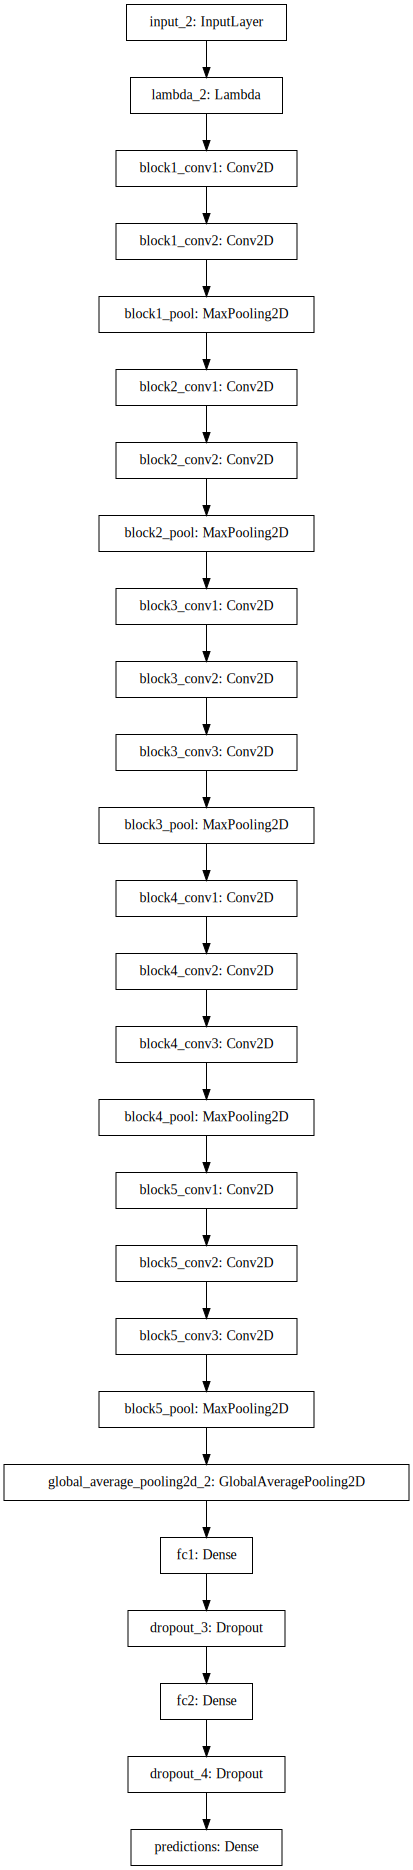

In [18]:
model.load_weights("model_6_weights.hdf5")
plot_model(model,show_shapes=True,to_file='vgg16_model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 绘制vgg16最佳模型的学习曲线

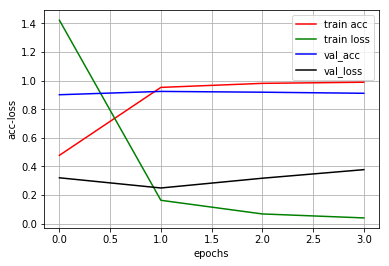

In [17]:
plt.figure()
plt.plot(hist.history["acc"], 'r', label='train acc')#plt.plot(x,y)，这个将数据画成曲线
plt.plot(hist.history["loss"], 'g', label='train loss')
plt.plot(hist.history["val_acc"],"b",label="val_acc")
plt.plot(hist.history["val_loss"],"k",label="val_loss")
plt.grid(True)#设置网格形式
plt.xlabel('epochs')
plt.ylabel('acc-loss')#给x，y轴加注释
plt.legend(loc="upper right")#设置图例显示位置
plt.show()

## cam模型可视化

参考 http://cnnlocalization.csail.mit.edu/

In [19]:
model=build_model_VGG16()
model.load_weights("model_6_weights.hdf5")

In [20]:
weights=model.layers[25].get_weights()[0]
weights2=model.layers[21].get_weights()[0]
model2=Model(model.input,[model.layers[18].output,model.output])

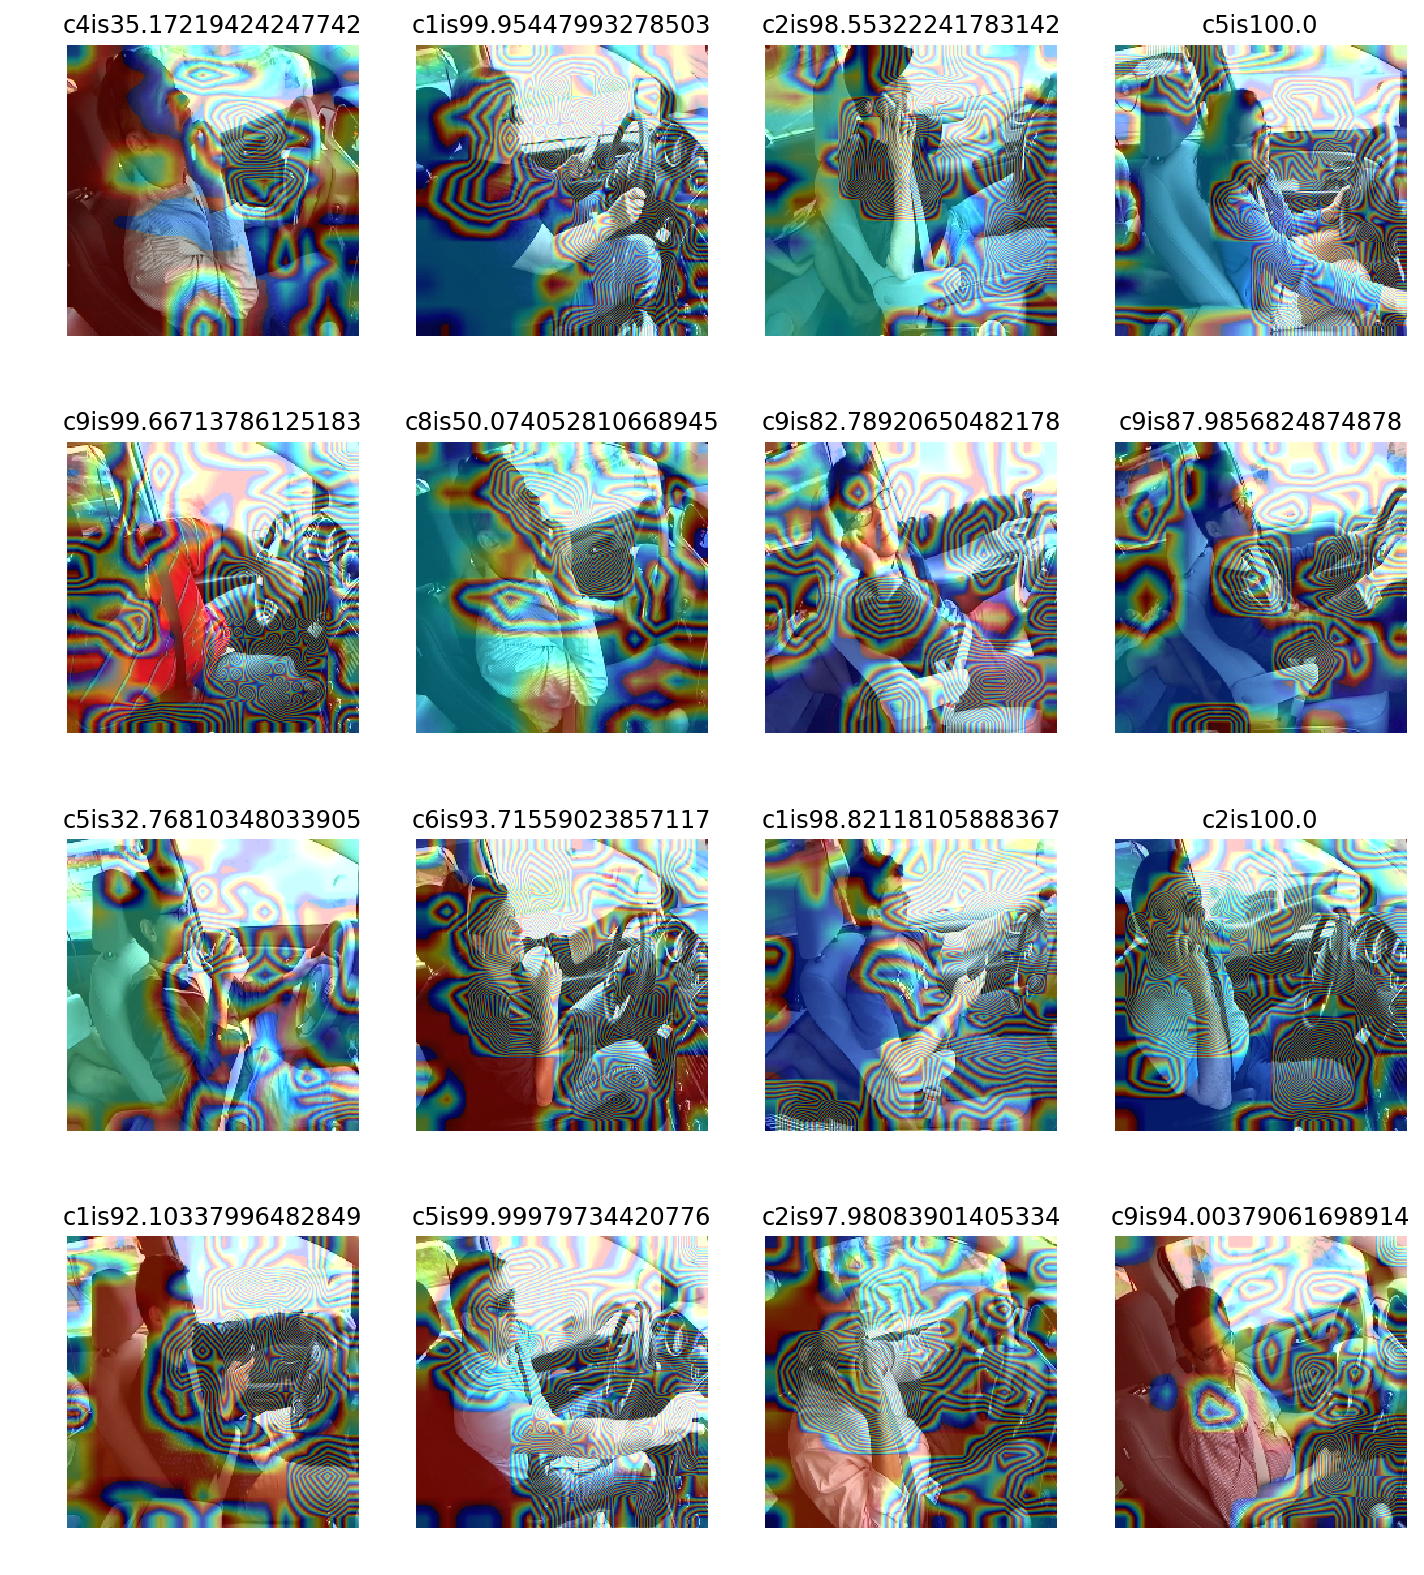

In [27]:
### import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.figure(figsize=(12,14))
file_list=os.listdir("./link/test")
for i in range(16):
    plt.subplot(4,4,i+1)
    name=random.sample(file_list,1)
    img_path="./link/test/"+name[0]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(img_rows,img_cols))
    x=img.copy()
    x = np.expand_dims(x, axis=0)
    out,prediction=model2.predict(x)
    prediction=prediction[0].tolist()
    prediction_max=max(prediction)
    prediction_index=prediction.index(prediction_max)
    out=out[0]
    cam=np.matmul(out,weights2)
    cam=np.matmul(cam,weights)
    cam=prediction_max*cam[:,:,prediction_index]
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam=cv2.resize(cam,(224,224))
    heatmap=cv2.applyColorMap(np.uint8(255*cam),cv2.COLORMAP_JET)
    out=cv2.addWeighted(img,0.8,heatmap,0.4,0)
    plt.title("c"+str(prediction_index)+"is"+str(prediction_max*100))
    plt.axis("off")
    plt.imshow(out[:,:,::-1])

# bagging 生成测试集

## 集成测试结果

在kaggle的比赛中，为了提高乘积，可以使用bagging的方式，集成多个模型的预测结果，相当于使用单一模型对图片的预测可能对分类划分并不特别精确，而引入多个模型以后，对一些划分“模糊”的图片，可以通过多个模型相互验证的情况进行划分，这里对8个模型选择其中的5个kaggel评分较好的模型模型集成提交,最后得分0.25

In [ ]:
data1=pd.read_csv("vgg1.csv")
data2=pd.read_csv("vgg3.csv")
data3=pd.read_csv("vgg4.csv")
data4=pd.read_csv("vgg6.csv")
data5=pd.read_csv("vgg8.csv")
data=data1
data["c0"]=(data1["c0"]+data2["c0"]+data3["c0"]+data4["c0"]+data5["c0"])/5
data["c1"]=(data1["c1"]+data2["c1"]+data3["c1"]+data4["c1"]+data5["c1"])/5
data["c2"]=(data1["c2"]+data2["c2"]+data3["c2"]+data4["c2"]+data5["c2"])/5
data["c3"]=(data1["c3"]+data2["c3"]+data3["c3"]+data4["c3"]+data5["c3"])/5
data["c4"]=(data1["c4"]+data2["c4"]+data3["c4"]+data4["c4"]+data5["c4"])/5
data["c5"]=(data1["c5"]+data2["c5"]+data3["c5"]+data4["c5"]+data5["c5"])/5
data["c6"]=(data1["c6"]+data2["c6"]+data3["c6"]+data4["c6"]+data5["c6"])/5
data["c7"]=(data1["c7"]+data2["c7"]+data3["c7"]+data4["c7"]+data5["c7"])/5
data["c8"]=(data1["c8"]+data2["c8"]+data3["c8"]+data4["c8"]+data5["c8"])/5
data["c9"]=(data1["c9"]+data2["c9"]+data3["c9"]+data4["c9"]+data5["c9"])/5
data.to_csv("5_folds_vgg.csv",index=False, sep=',')

# 使用半监督学习方式进一步提高结果

因为此项目中训练集少2万多图片，测试集较大有7万多图片，在CNN中越多的训练数据，可以得到越好的模型结果，而实际情况是，训练数据需要人工分类添加标签，所以难以获取或者成本较高，使用半监督学习的方式，即通过已经训练好的模型，在测试集中，选择那些置信度较高的图片，把这些图片根据预测结果添加伪标签，即通过模型生成了测试集的图片标签。把这些添加了伪标签的测试集数据，合并到训练集中，重新训练模型，可以在数据环节进一步提升模型的质量。

## 读入集成后的提交结果CSV文件

In [13]:
pred=pd.read_csv('5_folds_vgg.csv')

## 选择10000个置信度高于0.99的测试集图片生成伪标签

In [14]:
def create_pesudo_label_picture():  
    file_list=file_list=os.listdir("./link/test")
    train_X2=np.zeros((10000,img_rows,img_cols,3),dtype=np.uint8)
    train_Y2=np.zeros((10000,1),dtype=np.uint8)
    index=0
    for name in tqdm(file_list):
        feature=pred[pred["img"]==name]
        feature=np.array(feature[:1]).tolist()[0][:-1]
        if index>=10000:
            break
        elif max(feature)>0.99:
            img_path=os.path.join("./link/test",name)
            x= image.load_img(img_path, target_size=(img_rows, img_cols))
            x = image.img_to_array(x)
            x = np.expand_dims(x, axis=0)
            label=feature.index(max(feature))
            train_X2[index]=x
            train_Y2[index]=label
            index+=1        
    return train_X2,one_hot_encode(train_Y2)

## 读入伪标签图片内容

In [15]:
train_X2,train_Y2=create_pesudo_label_picture()

 23%|██▎       | 18389/79726 [04:10<13:54, 73.48it/s]

## 合并训练集函数

In [16]:
def merge_train_data(train_X,train_X2):
    i=0
    count_x=len(train_X)
    count_x2=len(train_X2)
    train_Xnew=np.zeros((count_x+count_x2,img_rows,img_cols,3),dtype=np.uint8)
    train_Ynew=np.zeros((count_x+count_x2,10),dtype=np.uint8)
    for i in range(count_x+count_x2):
        if(i<count_x):
            train_Xnew[i]=train_X[i]
            train_Ynew[i]=train_Y[i]
        else:
            index=0
            train_Xnew[i]=train_X2[index]
            train_Ynew[i]=train_Y2[index]
            index+=1
    return train_Xnew,train_Ynew

## 通过混合后的数据训练Vgg16模型

In [15]:
val_ID=['p026','p035','p042','p075']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_Xnew,train_Ynew=merge_train_data(train_X,train_X2)
train_gen,val_gen,test_gen=Augmentation_data(train_Xnew ,train_Ynew,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,9,train_gen,val_gen)
model.load_weights("model_9_weights.hdf5")
get_test_result(model,test_gen,"vgg9.csv")

Found 79726 images belonging to 1 classes.
9 round training is beging
Epoch 1/10
1811/1811 [==============================] - 1039s 574ms/step - loss: 1.1400 - acc: 0.5914 - val_loss: 0.4077 - val_acc: 0.8750
Epoch 2/10
1811/1811 [==============================] - 1022s 564ms/step - loss: 0.2130 - acc: 0.9376 - val_loss: 0.3336 - val_acc: 0.8965
Epoch 3/10
1811/1811 [==============================] - 1019s 563ms/step - loss: 0.0852 - acc: 0.9771 - val_loss: 0.4040 - val_acc: 0.8779
Epoch 4/10
1811/1811 [==============================] - 1017s 562ms/step - loss: 0.0484 - acc: 0.9875 - val_loss: 0.6422 - val_acc: 0.8713
9 round training finished
Now to predict result!
4983/4983 [==============================] - 866s 174ms/step
Creating datasheet!
Test result file vgg9.csv generated!


该模型提交kaggel ,private score为0.40

In [16]:
val_ID=['p015','p051','p072']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_Xnew,train_Ynew=merge_train_data(train_X,train_X2)
train_gen,val_gen,test_gen=Augmentation_data(train_Xnew ,train_Ynew,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,10,train_gen,val_gen)
model.load_weights("model_10_weights.hdf5")
get_test_result(model,test_gen,"vgg10.csv")

Found 79726 images belonging to 1 classes.
10 round training is beging
Epoch 1/10
1809/1809 [==============================] - 1038s 574ms/step - loss: 1.2526 - acc: 0.5385 - val_loss: 0.8623 - val_acc: 0.7145
Epoch 2/10
1809/1809 [==============================] - 1027s 567ms/step - loss: 0.2751 - acc: 0.9178 - val_loss: 0.5876 - val_acc: 0.8424
Epoch 3/10
1809/1809 [==============================] - 1024s 566ms/step - loss: 0.0867 - acc: 0.9774 - val_loss: 0.6182 - val_acc: 0.8426
Epoch 4/10
1809/1809 [==============================] - 1017s 562ms/step - loss: 0.0511 - acc: 0.9874 - val_loss: 0.8612 - val_acc: 0.8174
10 round training finished
Now to predict result!
4983/4983 [==============================] - 866s 174ms/step
Creating datasheet!
Test result file vgg10.csv generated!


该模型提交kaggle后，private score分数为0.38

In [18]:
val_ID=['p024','p039','p061']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_Xnew,train_Ynew=merge_train_data(train_X,train_X2)
train_gen,val_gen,test_gen=Augmentation_data(train_Xnew ,train_Ynew,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,11,train_gen,val_gen)
model.load_weights("model_11_weights.hdf5")
get_test_result(model,test_gen,"vgg11.csv")

Found 79726 images belonging to 1 classes.
11 round training is beging
Epoch 1/10
1859/1859 [==============================] - 1055s 568ms/step - loss: 1.1906 - acc: 0.5780 - val_loss: 0.6537 - val_acc: 0.8492
Epoch 2/10
1859/1859 [==============================] - 1044s 562ms/step - loss: 0.2223 - acc: 0.9345 - val_loss: 0.4694 - val_acc: 0.8697
Epoch 3/10
1859/1859 [==============================] - 1041s 560ms/step - loss: 0.0835 - acc: 0.9768 - val_loss: 0.4919 - val_acc: 0.8924
Epoch 4/10
1859/1859 [==============================] - 1041s 560ms/step - loss: 0.0541 - acc: 0.9857 - val_loss: 0.4020 - val_acc: 0.9133
Epoch 5/10
1859/1859 [==============================] - 1041s 560ms/step - loss: 0.0378 - acc: 0.9894 - val_loss: 0.5367 - val_acc: 0.9211
Epoch 6/10
1859/1859 [==============================] - 1038s 558ms/step - loss: 0.0279 - acc: 0.9923 - val_loss: 0.4187 - val_acc: 0.9159
11 round training finished
Now to predict result!
4983/4983 [==============================] - 

该模型提交kaggle后，private score分数为0.42

In [ ]:
val_ID=['p021','p022','p056']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_Xnew,train_Ynew=merge_train_data(train_X,train_X2)
train_gen,val_gen,test_gen=Augmentation_data(train_Xnew ,train_Ynew,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,12,train_gen,val_gen)
model.load_weights("model_12_weights.hdf5")
get_test_result(model,test_gen,"vgg12.csv")

Found 79726 images belonging to 1 classes.
12 round training is beging
Epoch 1/10
1823/1823 [==============================] - 1037s 569ms/step - loss: 1.2390 - acc: 0.5563 - val_loss: 0.7755 - val_acc: 0.7708
Epoch 2/10
1823/1823 [==============================] - 1025s 562ms/step - loss: 0.2876 - acc: 0.9112 - val_loss: 0.3195 - val_acc: 0.9090
Epoch 3/10
1823/1823 [==============================] - 1023s 561ms/step - loss: 0.0930 - acc: 0.9750 - val_loss: 0.4415 - val_acc: 0.9151
Epoch 4/10
1823/1823 [==============================] - 1022s 561ms/step - loss: 0.0526 - acc: 0.9863 - val_loss: 0.4037 - val_acc: 0.9191
12 round training finished
Now to predict result!
 879/4983 [====>.........................] - ETA: 11:50

该模型提交kaggle后,private score分数为 0.41

In [20]:
val_ID=['p002','p041','p050']
train_X,train_Y,val_X,val_Y=read_picture(val_ID)
train_Xnew,train_Ynew=merge_train_data(train_X,train_X2)
train_gen,val_gen,test_gen=Augmentation_data(train_Xnew ,train_Ynew,val_X,val_Y)
model=build_model_VGG16()
hist=fit_model(model,13,train_gen,val_gen)
model.load_weights("model_13_weights.hdf5")
get_test_result(model,test_gen,"vgg13.csv")

Found 79726 images belonging to 1 classes.
13 round training is beging
Epoch 1/10
1894/1894 [==============================] - 1057s 558ms/step - loss: 1.1772 - acc: 0.5827 - val_loss: 0.6368 - val_acc: 0.7896
Epoch 2/10
1894/1894 [==============================] - 1049s 554ms/step - loss: 0.2457 - acc: 0.9229 - val_loss: 0.4098 - val_acc: 0.8693
Epoch 3/10
1894/1894 [==============================] - 1050s 555ms/step - loss: 0.0894 - acc: 0.9754 - val_loss: 0.5580 - val_acc: 0.8561
Epoch 4/10
1894/1894 [==============================] - 1049s 554ms/step - loss: 0.0477 - acc: 0.9869 - val_loss: 1.0155 - val_acc: 0.8302
13 round training finished
Now to predict result!
4983/4983 [==============================] - 864s 173ms/step
Creating datasheet!
Test result file vgg13.csv generated!


此模型提交kaggle后，pvirate socre 为0.42

## 集成半监督学习后的模型

In [3]:
data1=pd.read_csv("vgg9.csv")
data2=pd.read_csv("vgg10.csv")
data3=pd.read_csv("vgg11.csv")
data4=pd.read_csv("vgg12.csv")
data5=pd.read_csv("vgg13.csv")
data=data1
data["c0"]=(data1["c0"]+data2["c0"]+data3["c0"]+data4["c0"]+data5["c0"])/5
data["c1"]=(data1["c1"]+data2["c1"]+data3["c1"]+data4["c1"]+data5["c1"])/5
data["c2"]=(data1["c2"]+data2["c2"]+data3["c2"]+data4["c2"]+data5["c2"])/5
data["c3"]=(data1["c3"]+data2["c3"]+data3["c3"]+data4["c3"]+data5["c3"])/5
data["c4"]=(data1["c4"]+data2["c4"]+data3["c4"]+data4["c4"]+data5["c4"])/5
data["c5"]=(data1["c5"]+data2["c5"]+data3["c5"]+data4["c5"]+data5["c5"])/5
data["c6"]=(data1["c6"]+data2["c6"]+data3["c6"]+data4["c6"]+data5["c6"])/5
data["c7"]=(data1["c7"]+data2["c7"]+data3["c7"]+data4["c7"]+data5["c7"])/5
data["c8"]=(data1["c8"]+data2["c8"]+data3["c8"]+data4["c8"]+data5["c8"])/5
data["c9"]=(data1["c9"]+data2["c9"]+data3["c9"]+data4["c9"]+data5["c9"])/5
data.to_csv("final_vgg.csv",index=False, sep=',')

最终模型提交kggle后，private score 0.23